In [16]:
import os
os.chdir( "/home/lucasfuzato/TCC/CODE" )

import torch as tc
device = "cuda" if tc.cuda.is_available() else "cpu"
print( device )

import torch.nn as tnn
import torch.optim as top
import torch.nn.functional as tfun
import torch.autograd as tgd

import pandas as pd
pos_df = pd.read_csv( "data/pend_sim.csv" )

from typing import *
from itertools import *
from src.util.aux_fun import *

cuda


In [29]:
def make_net( 
        shape : Tuple, 
        activation : tnn.Module = tnn.ReLU,
        omega = 0,
        lr : float = 1e-3
    ):

    # making the mlp regressor
    net = tnn.Sequential()
    n = len( shape )
    for i in range( 1 , n ):
        in_size = shape[ i - 1 ]
        out_size = shape[ i ]
        net.append( tnn.Linear( in_size , out_size , dtype = tc.float64 , device = device) )
        if i < n - 1:
            net.append( activation() )
    # net = net.to( device )

    # optimizer
    opm = top.Adam( net.parameters() , lr = lr , weight_decay = omega )

    return net , opm

def time_grad( t : tc.Tensor , state : tc.Tensor ) -> tc.Tensor:

    '''
    computes the time gradient of state in regards to t
    '''

    # t_clone = tc.tensor( t , requires_grad = True )
    return tgd.grad(
        state,
        t,
        grad_outputs = tc.ones_like( state ),
        create_graph = True
    )[ 0 ]


def pinn_fit_fun( net : tnn.Module , opm : top.Optimizer , time_interval , num_points , alpha : float = 0.5  ):

    def make_collation_points( ):

        min_t , max_t = time_interval
        rd_pts = tc.rand( ( num_points , 1 ) , dtype = tc.float64, device = device , requires_grad = True )
        c_pts = min_t + ( max_t - min_t )*rd_pts

        return c_pts

    def physics_reg( c_pts ):

        '''
        regularization factor to make the net obey the laws of physics
        throughout the entire domain of the problem
        '''

        # network aproximation
        pos_hat = net( c_pts )
        t1_hat  = pos_hat.T[ 0 ]
        o1_hat  = time_grad( c_pts , t1_hat)
        t2_hat  = pos_hat.T[ 1 ]
        o2_hat  = time_grad( c_pts , t2_hat)

        # detached compies from tensors
        t1 = tc.clone( t1_hat ).detach().unsqueeze( 1 )
        o1 = tc.clone( o1_hat ).detach()
        t2 = tc.clone( t2_hat ).detach().unsqueeze( 1 )
        o2 = tc.clone( o2_hat ).detach()

        # expected acc for pendulum 1 
        p1_num1 = -3*tc.sin( t1 )
        p1_num2 = -tc.sin( t1 - 2*t2 )
        p1_num3 = -2*tc.sin( t1 - t2 )*( o2**2 + ( o1**2 )*tc.cos( t1 - t2 ) )
        den = 3 - tc.cos( 2*t1 - 2*t2 )

        acc_1 = ( p1_num1 + p1_num2 + p1_num3 )/den

        # real acc for pendulum 1 and physics loss
        o1_dot = time_grad( c_pts , o1_hat )
        loss_1 = tfun.mse_loss( o1_dot , acc_1 )

        # expected acc for pendulum 2 
        p2_num1 = 2*tc.sin( t1 - t2 )
        p2_num2 = 2*( o1**2 + tc.cos( t1 ) )
        p2_num3 = ( o2**2 )*tc.cos( t1 - t2 )

        acc_2 = ( p2_num1 + p2_num2 + p2_num3 )/den

        # real acc for pendulum 2 and physics loss
        o2_dot = time_grad( c_pts , o2_hat )
        loss_2 = tfun.mse_loss( o2_dot , acc_2 )
        

        return ( loss_1 + loss_2 )/2


    def update( t : tc.Tensor , pos : tc.Tensor ):

        net.zero_grad()

        # ---------------------------------
        # data loss
        pos_hat = net( t )
        data_loss = tfun.mse_loss( pos , pos_hat )

        # --------------------------------
        # physics loss
        c_pts = make_collation_points()
        p_loss = physics_reg( c_pts )

        loss = data_loss + p_loss*alpha
        loss.backward()
        opm.step()
        
    return update

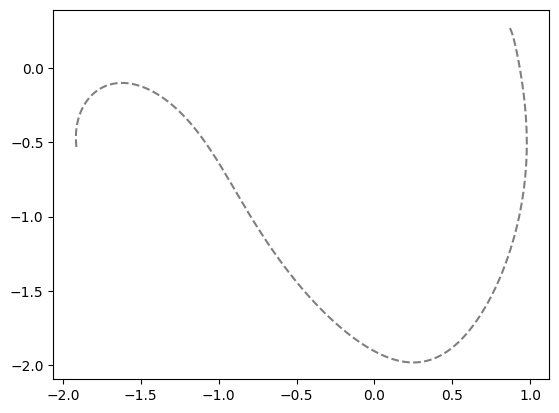

In [11]:
sample = sample_coordinates( pos_df , start = 50 , end = 55.3 )
cart_sample = from_polar( sample )

x , y = cart_sample[ "x2" ] , cart_sample[ "y2" ]
fig , ax = plt.subplots()
ax.plot( x , y , linestyle = "--" , color = "grey" )
plt.show()

In [30]:
standard_shp = ( 1 , 128 , 128 , 2 )
net , opm = make_pinn( standard_shp )

time_interval = ( 0 , 1200 )
num_cpts = 100
pinn_fit = pinn_fit_fun( net , opm , time_interval , num_cpts )

train_loader , test_loader = make_sampler( pos_df )

t , pos = next( iter( train_loader ) )
t = t.unsqueeze(1).to( device )
pos = pos.to( device )
pinn_fit( t , pos )

torch.Size([100, 1])
torch.Size([100, 1])
